In [76]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from optionsfactory import StructuredProductFactory

## Testing the Synthetic Forward

In [77]:
fwd_price = 100
volatility = 0.20
time_to_exp = 0.50
t = 0
int_rate = 0.06
div_yield = 0.01

In [78]:
sfwd = StructuredProductFactory.synthetic_forward(fwd_price=fwd_price,
                                                  time_to_exp=time_to_exp,
                                                  volatility=volatility,
                                                  int_rate=int_rate,
                                                  div_yield=div_yield)

In [79]:
spot_prices = np.linspace(fwd_price - fwd_price/2,
                          fwd_price + fwd_price/2, 
                          100)

In [80]:
sfwd_payoff = sfwd.price(spot=spot_prices, t=0)
fwd_payoff = spot_prices * np.exp(-div_yield * time_to_exp) - fwd_price * np.exp(-int_rate * time_to_exp)

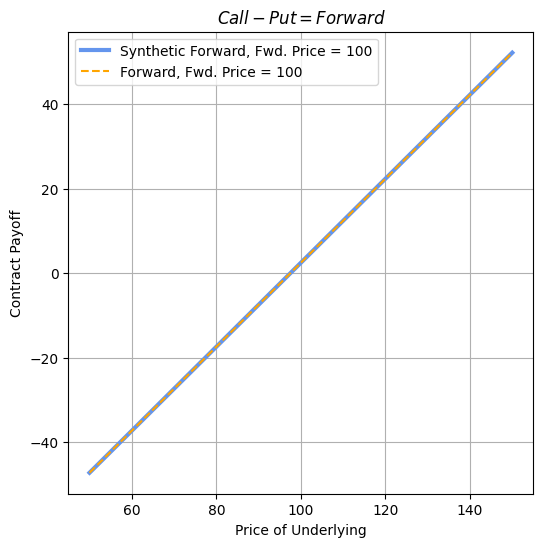

In [81]:
plt.figure(figsize=(6,6))
plt.plot(spot_prices, sfwd_payoff, label=f"Synthetic Forward, Fwd. Price = {fwd_price:.0f}", linewidth=3, color="cornflowerblue")
plt.plot(spot_prices, fwd_payoff, label=f"Forward, Fwd. Price = {fwd_price:.0f}", linestyle="--", linewidth=1.5, color="orange")
plt.legend(loc="upper left")
plt.xlabel("Price of Underlying")
plt.ylabel("Contract Payoff")
plt.title(r"$Call - Put = Forward$")
plt.grid();

## Testing Structured Products

### Defining a plotting function

In [82]:
def plot_price_greeks(product, spot_prices, ts, desc_title):
    days_to_exp = np.floor((time_to_exp - ts) * 360) # using days/360 convention
    colors = sns.color_palette("ch:s=.25,rot=-.25", n_colors=len(ts))
    fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(25, 5), sharex=True)
    for (t, days, color) in zip(ts, days_to_exp, colors):
        payoff = product.price(spot=spot_prices, t=t)
        axs[0].plot(spot_prices, payoff, 
                        label=f"{days:.0f} days to expiry",
                        linewidth=1.5, color=color)
        axs[0].set_xlabel("Price of Underlying")
        axs[0].set_ylabel("Contract Value")
        axs[0].set_title("Price")
        axs[0].grid()
        product_delta = product.get_delta(spot=spot_prices, t=t)
        product_gamma = product.get_gamma(spot=spot_prices, t=t)
        product_theta = product.get_theta(spot=spot_prices, t=t)
        product_vega = product.get_vega(spot=spot_prices, t=t)
        titles = ["Delta", "Gamma", "Theta", "Vega"]
        yvalues = [product_delta, product_gamma, product_theta, product_vega]
        for i in range(4):
            axs[i+1].plot(spot_prices, yvalues[i], 
                        linewidth=1.5, color=color)
            axs[i+1].set_xlabel("Price of Underlying")
            axs[i+1].set_ylabel(f"Contract {titles[i]}")
            axs[i+1].set_title(f"{titles[i]}")
            axs[i+1].grid()    
    fig.legend(loc="upper center", bbox_to_anchor=(-.04, .6), ncol=1)
    plt.suptitle(desc_title)
    plt.tight_layout()
    plt.show()

### 1. Put Spreads and Call Spreads

In [83]:
lower_strike = 90
upper_strike = 110
time_to_exp = 30/360
volatility = 0.30

In [84]:
put_sp = StructuredProductFactory.bear_spread(lower_strike=lower_strike,
                                              upper_strike=upper_strike,
                                              time_to_exp=time_to_exp,
                                              volatility=volatility,
                                              int_rate=int_rate,
                                              div_yield=div_yield)

In [85]:
call_sp = StructuredProductFactory.bull_spread(lower_strike=lower_strike,
                                               upper_strike=upper_strike,
                                               time_to_exp=time_to_exp,
                                               volatility=volatility,
                                               int_rate=int_rate,
                                               div_yield=div_yield)

In [86]:
spot_prices = np.linspace(lower_strike-lower_strike/4, upper_strike+lower_strike/4, 100)
ts = np.linspace(0, time_to_exp-1/360, 5) # using days/360 year convention

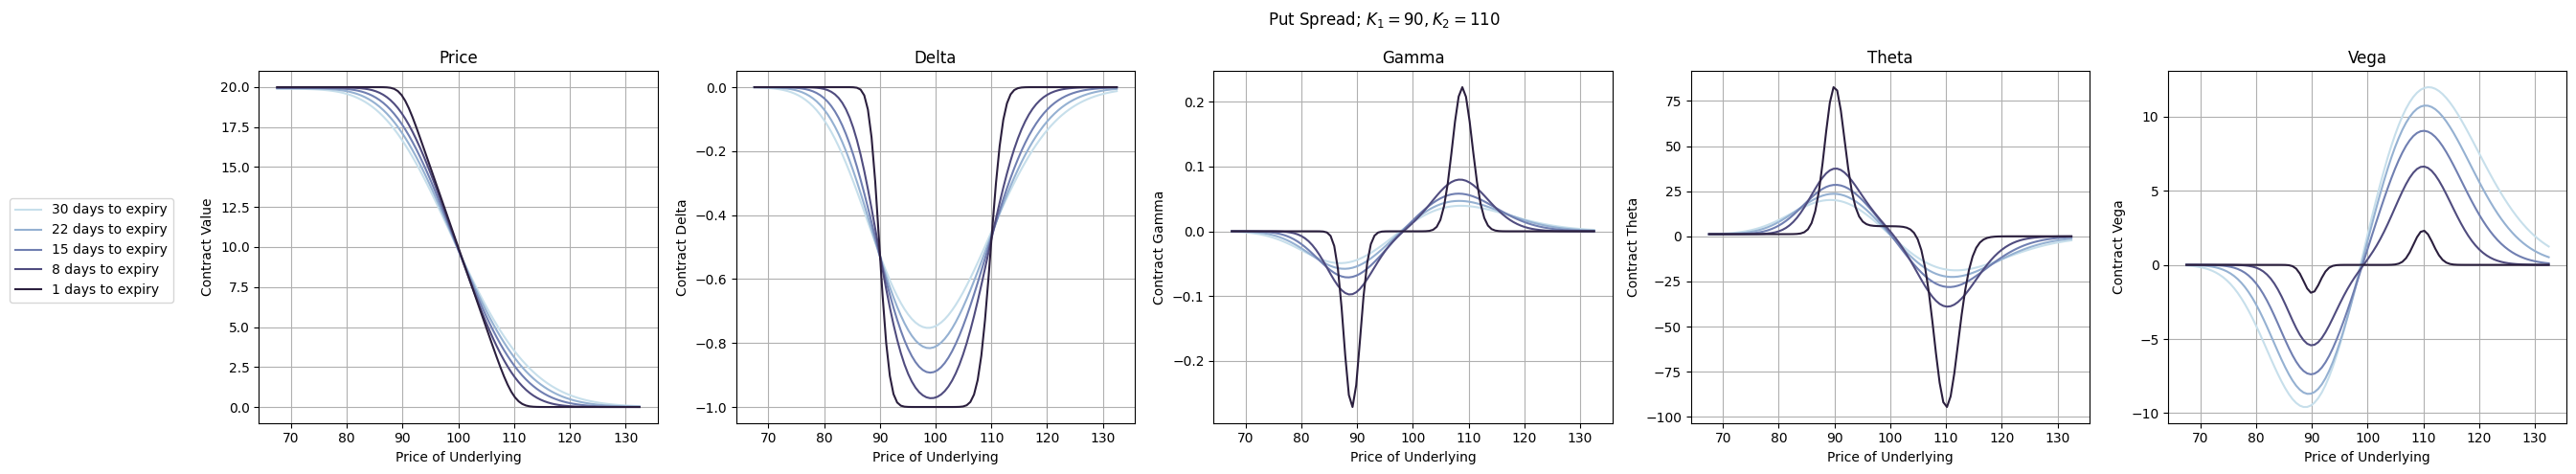

In [87]:
plot_price_greeks(put_sp, spot_prices, ts, f"Put Spread; $K_1={lower_strike:.0f}, K_2={upper_strike:.0f}$")

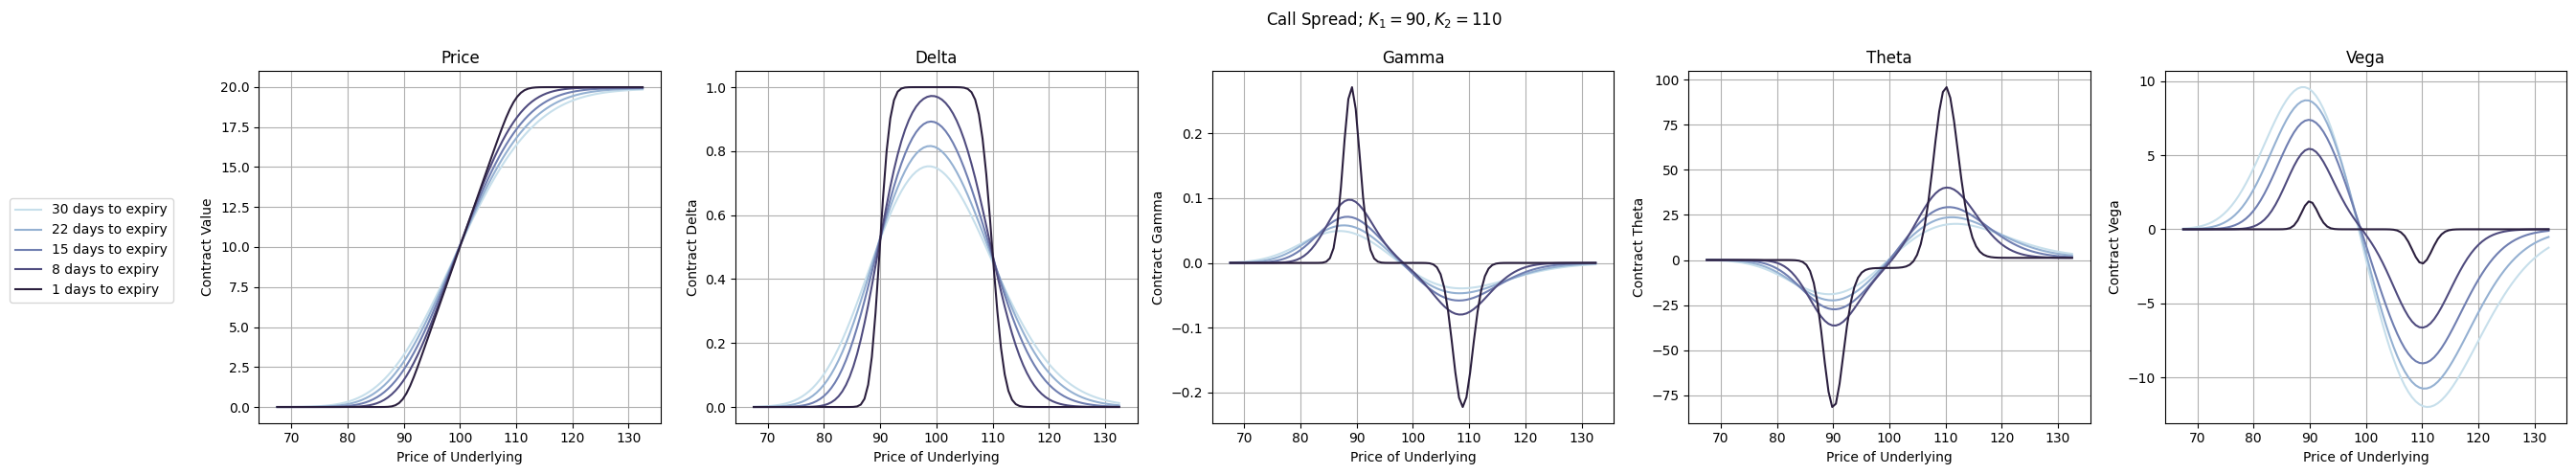

In [88]:
plot_price_greeks(call_sp, spot_prices, ts, f"Call Spread; $K_1={lower_strike:.0f}, K_2={upper_strike:.0f}$")

### 2. Long and Short Straddles

In [89]:
strike_price = 100

In [90]:
long_straddle = StructuredProductFactory.straddle(strike=strike_price,
                                                  time_to_exp=time_to_exp,
                                                  volatility=volatility,
                                                  int_rate=int_rate,
                                                  div_yield=div_yield)

In [91]:
# we can create a short straddle by creating a straddle and flipping the sign for 'weights'
import copy
short_straddle = copy.deepcopy(long_straddle)
short_straddle.weights = long_straddle.weights * -1

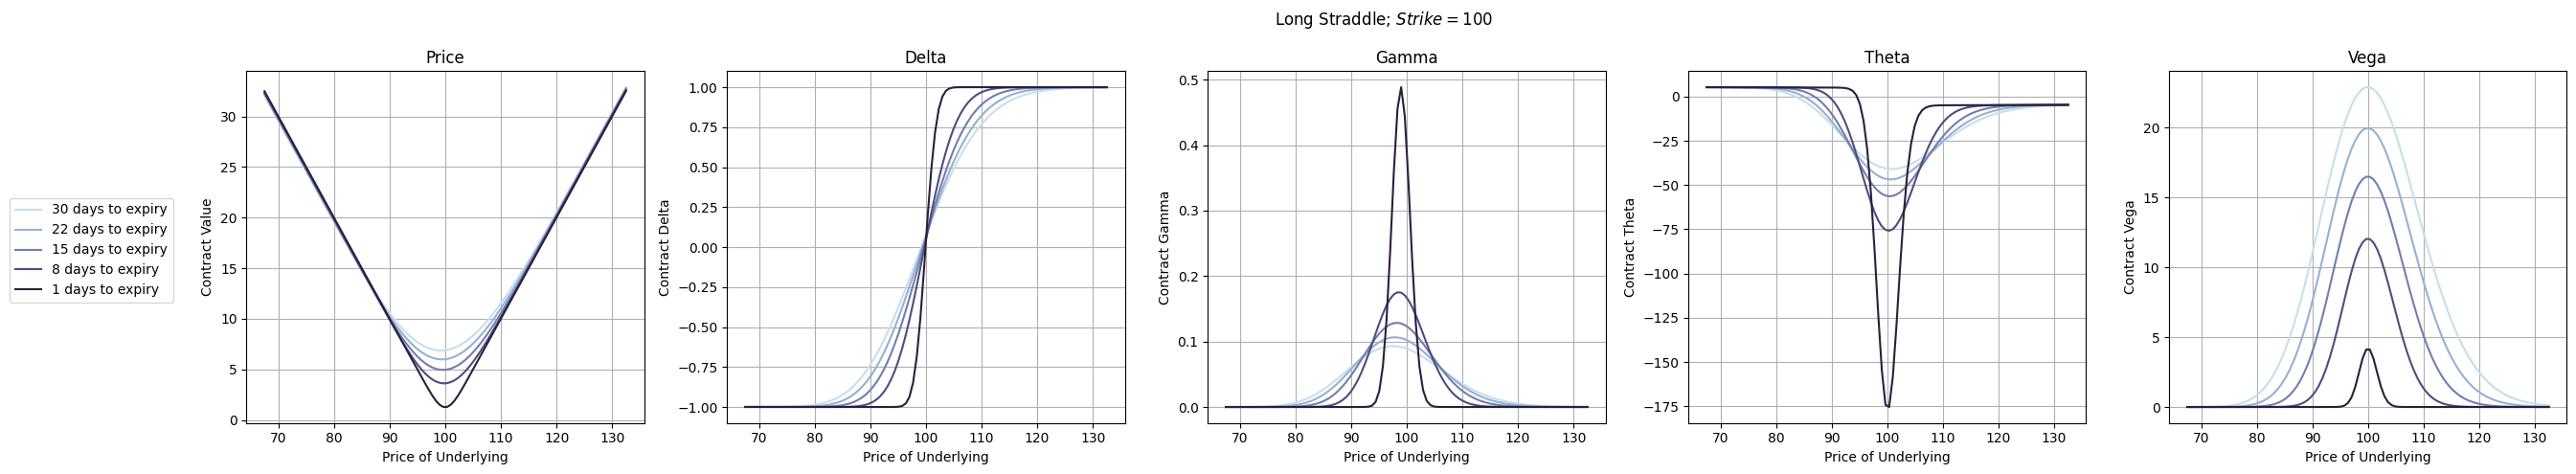

In [92]:
plot_price_greeks(long_straddle, spot_prices, ts, f"Long Straddle; $Strike={strike_price:.0f}$")

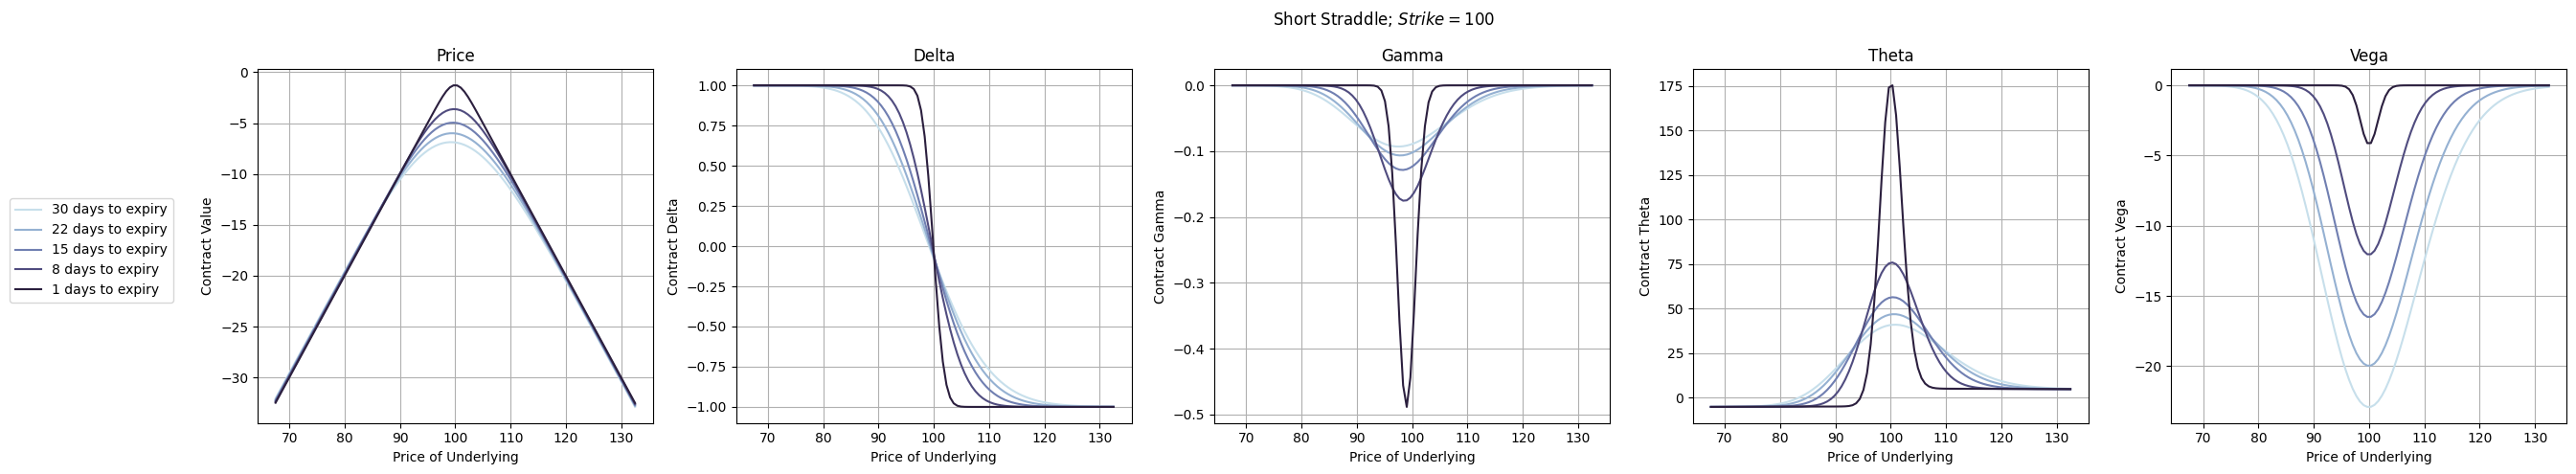

In [93]:
plot_price_greeks(short_straddle, spot_prices, ts, f"Short Straddle; $Strike={strike_price:.0f}$")

### 3. Long and Short Strangle

In [94]:
long_strangle = StructuredProductFactory.strangle(lower_strike=lower_strike,
                                                  upper_strike=upper_strike,
                                                  time_to_exp=time_to_exp,
                                                  volatility=volatility,
                                                  int_rate=int_rate,
                                                  div_yield=div_yield)

short_strangle = copy.deepcopy(long_strangle)
short_strangle.weights = long_strangle.weights * -1 # flip the weights to create a short version of product

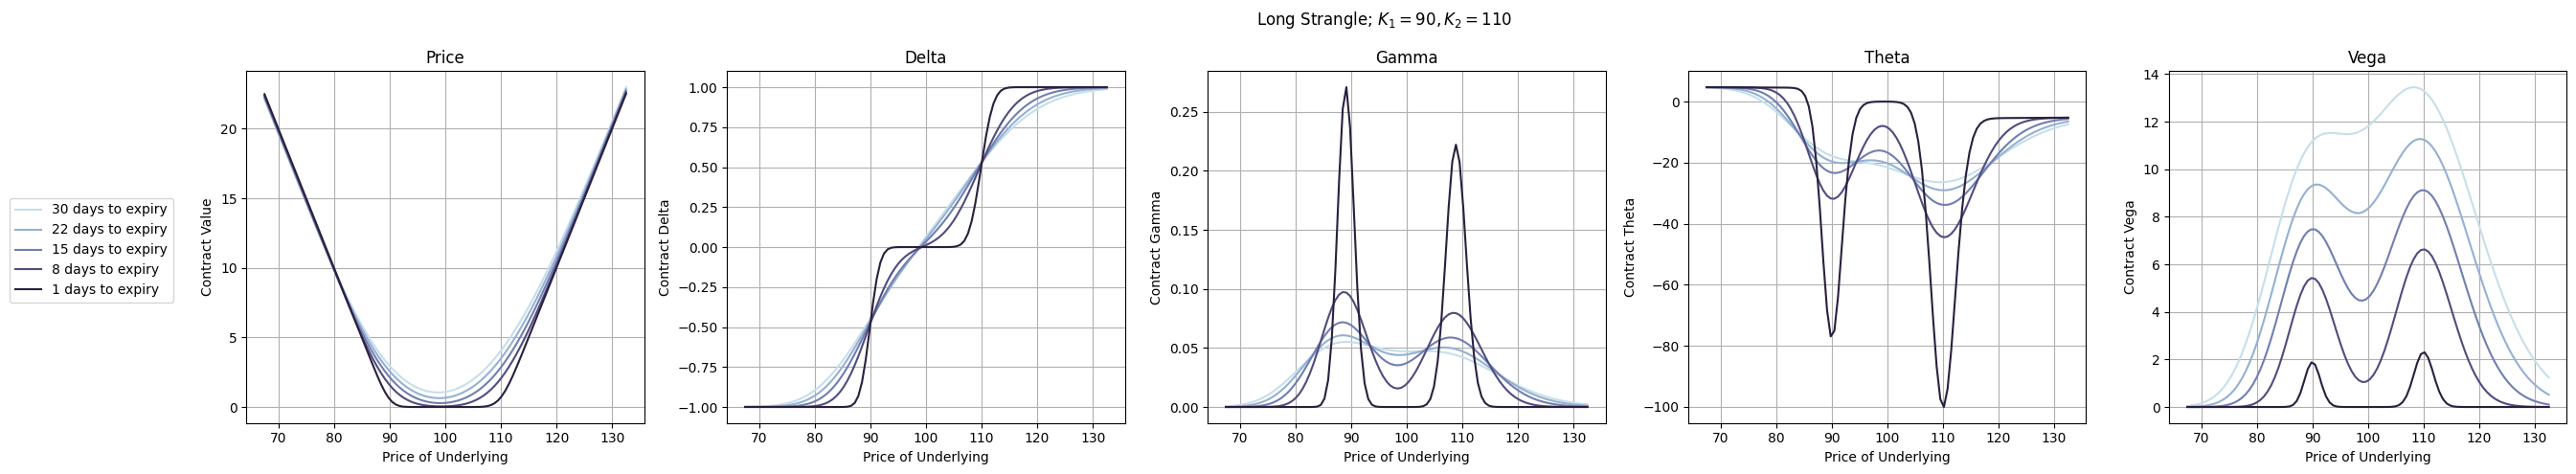

In [95]:
plot_price_greeks(long_strangle, spot_prices, ts, f"Long Strangle; $K_1={lower_strike:.0f}, K_2={upper_strike:.0f}$")

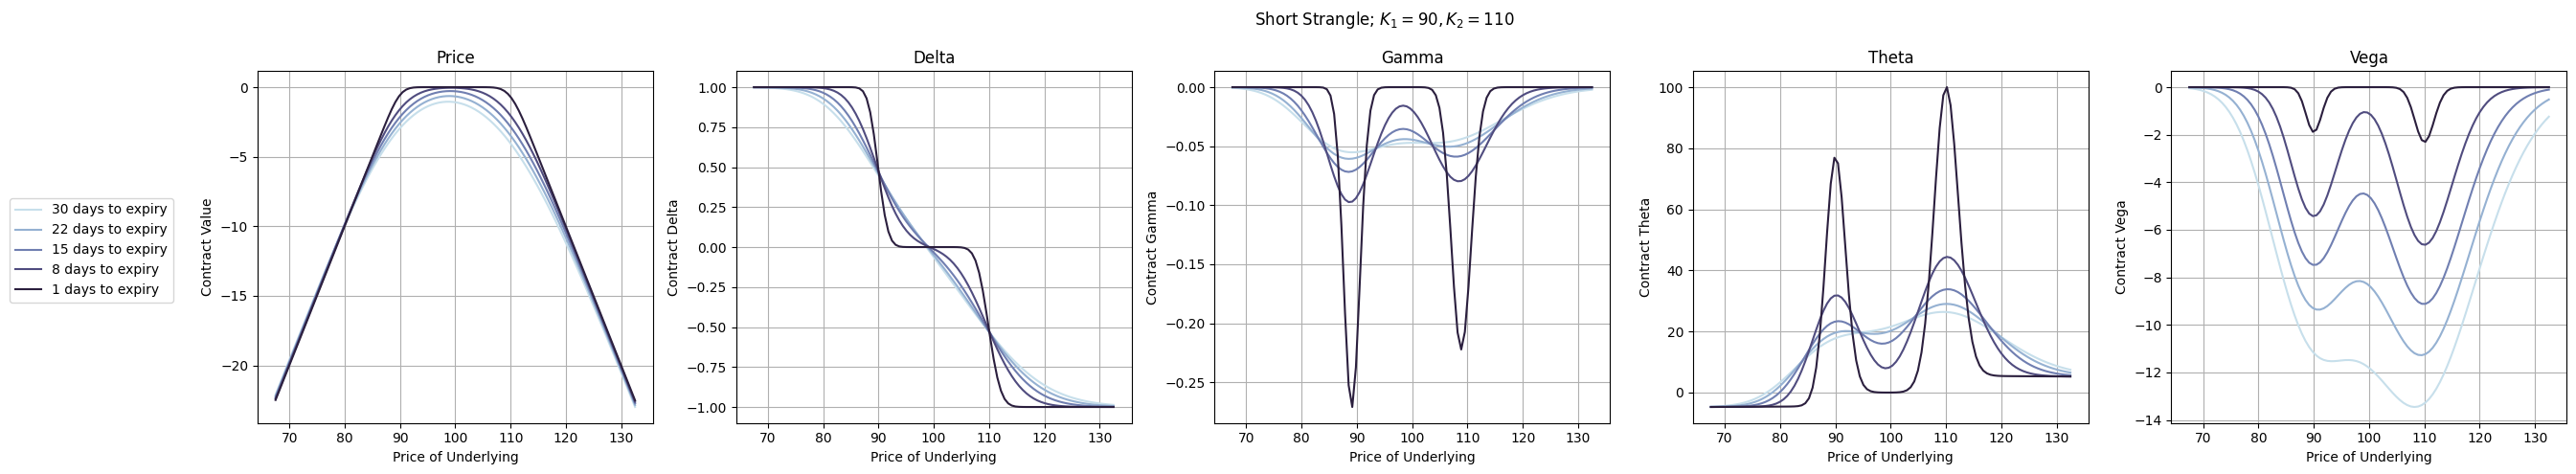

In [96]:
plot_price_greeks(short_strangle, spot_prices, ts, f"Short Strangle; $K_1={lower_strike:.0f}, K_2={upper_strike:.0f}$")

### 4. Long and Short Butterfly

In [97]:
width = 30

In [98]:
long_butterfly = StructuredProductFactory.butterfly(width=width,
                                                    center_strike=strike_price,
                                                    time_to_exp=time_to_exp,
                                                    int_rate=int_rate,
                                                    div_yield=div_yield)

In [99]:
short_butterfly = copy.deepcopy(long_butterfly)
short_butterfly.weights = long_butterfly.weights * -1 # flip the weights to create a short version of product

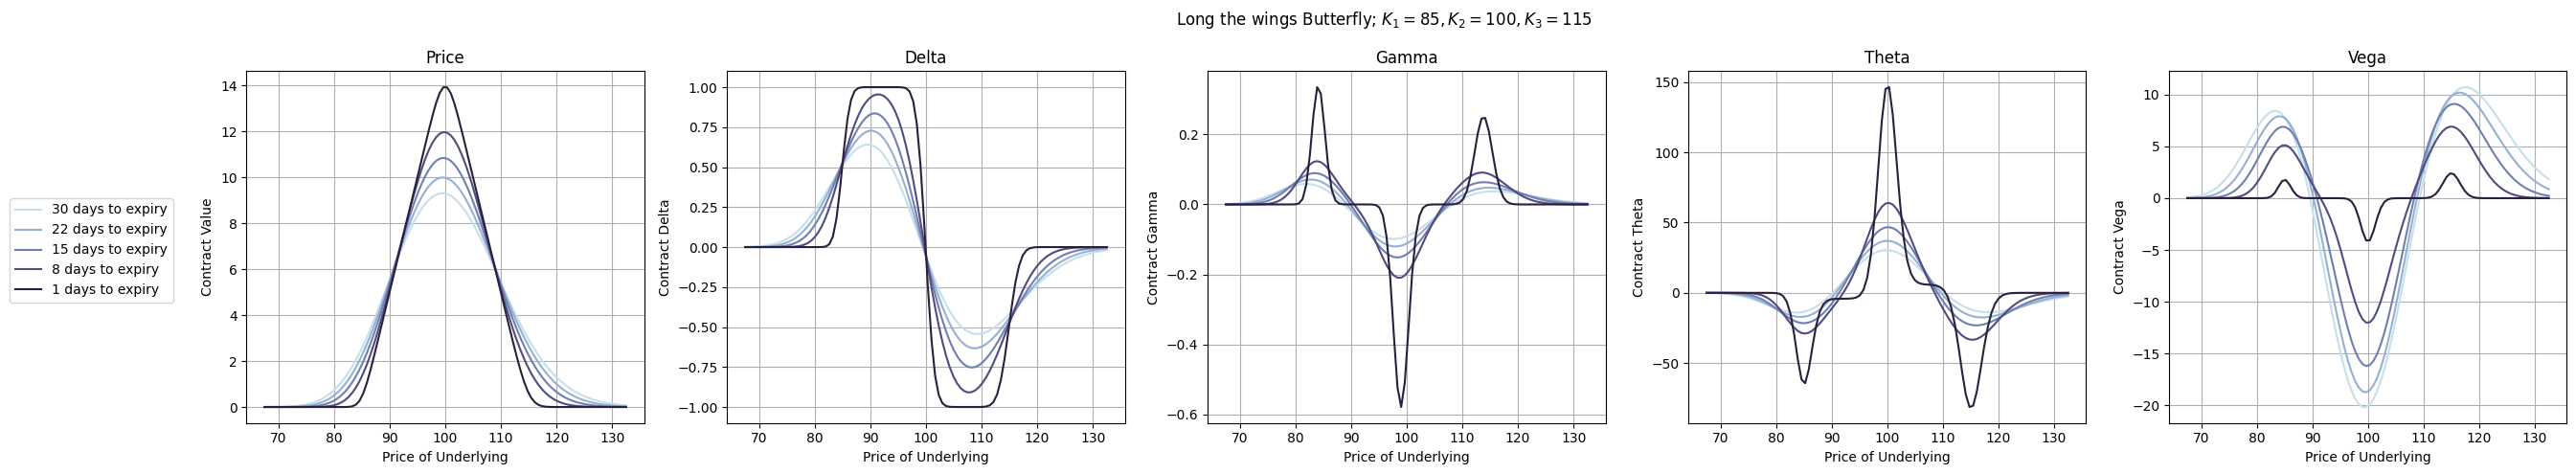

In [100]:
plot_price_greeks(long_butterfly, spot_prices, ts, 
                  f"Long the wings Butterfly; $K_1={strike_price-width/2:.0f}, K_2={strike_price:.0f}, K_3={strike_price+width/2:.0f}$")

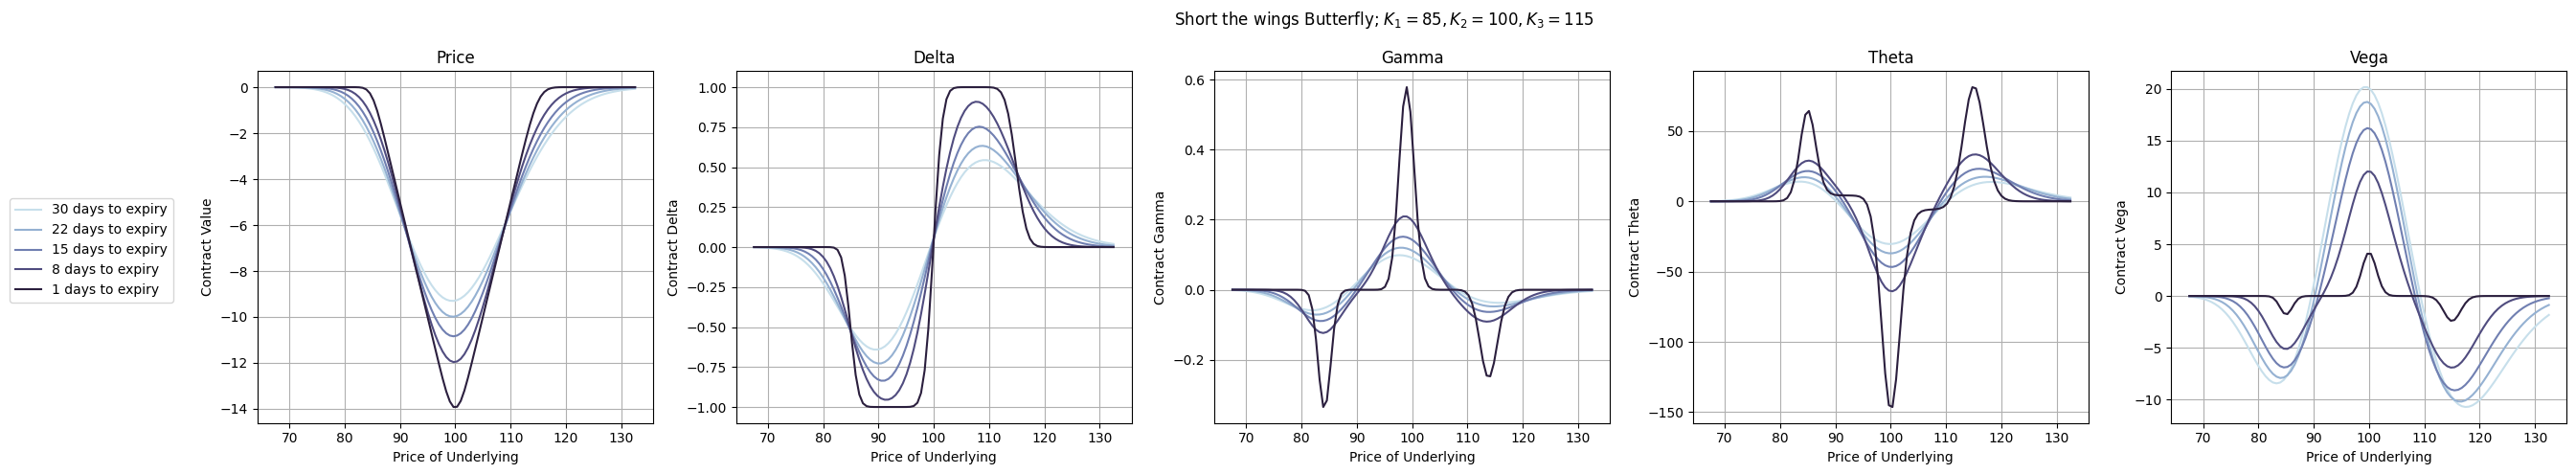

In [101]:
plot_price_greeks(short_butterfly, spot_prices, ts, 
                  f"Short the wings Butterfly; $K_1={strike_price-width/2:.0f}, K_2={strike_price:.0f}, K_3={strike_price+width/2:.0f}$")

### 5. Long and Short Condor

In [102]:
width = 20

In [103]:
long_condor = StructuredProductFactory.condor(width=width,
                                              lower_strike=lower_strike,
                                              upper_strike=upper_strike,
                                              time_to_exp=time_to_exp,
                                              volatility=volatility,
                                              int_rate=int_rate,
                                              div_yield=div_yield)

In [104]:
short_condor = copy.deepcopy(long_condor)
short_condor.weights = long_condor.weights * -1 # flip the weights to create a short version of product

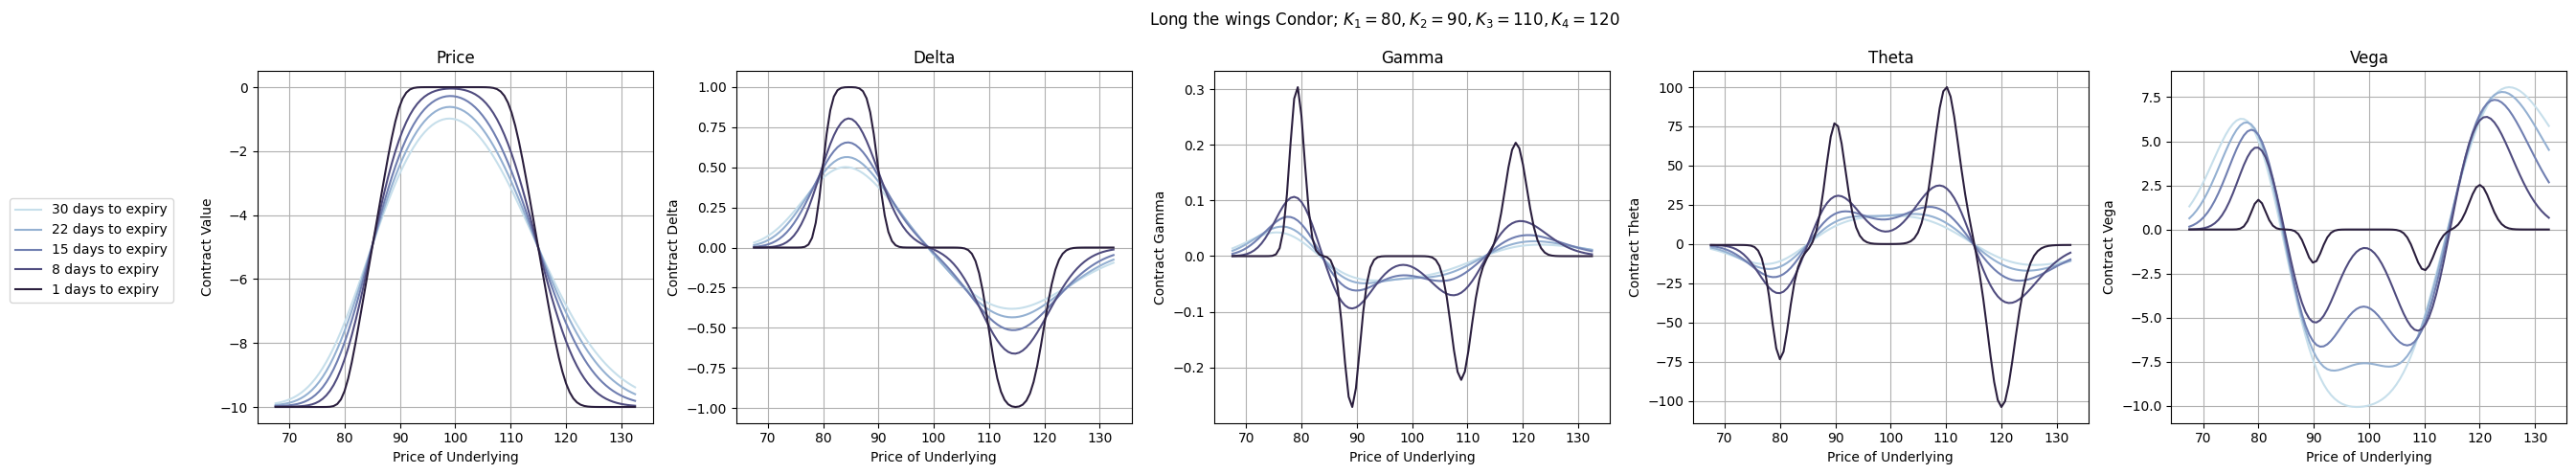

In [105]:
plot_price_greeks(long_condor, spot_prices, ts, 
                  f"Long the wings Condor; $K_1={lower_strike-width/2:.0f}, K_2={lower_strike:.0f}, K_3={upper_strike:.0f}, K_4={upper_strike+width/2:.0f}$")

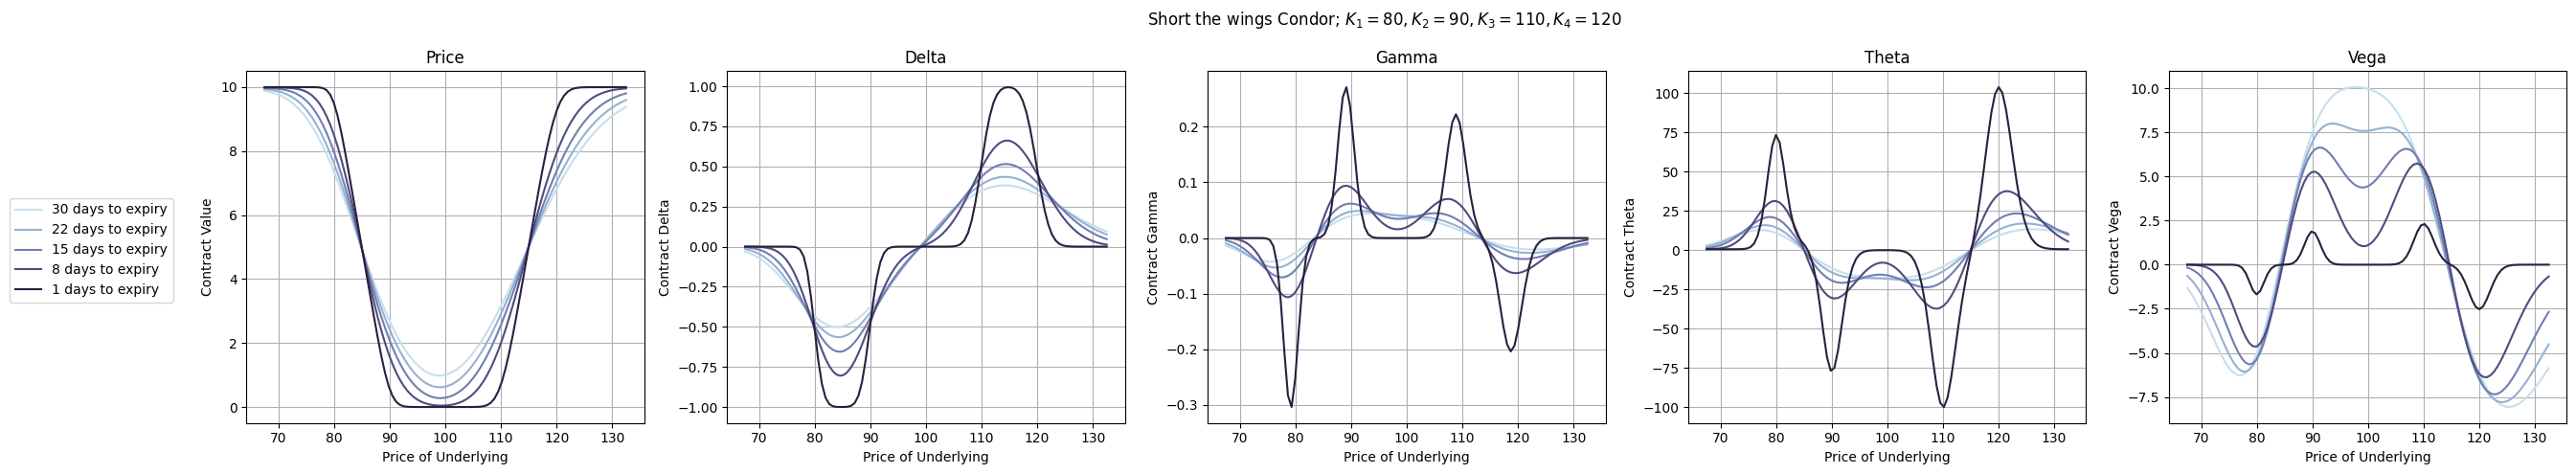

In [106]:
plot_price_greeks(short_condor, spot_prices, ts, 
                  f"Short the wings Condor; $K_1={lower_strike-width/2:.0f}, K_2={lower_strike:.0f}, K_3={upper_strike:.0f}, K_4={upper_strike+width/2:.0f}$")

### 6. Long and Short Call Christmas Tree

In [107]:
long_xmascall = StructuredProductFactory.call_xmastree(lower_strike=lower_strike,
                                                       center_strike=strike_price,
                                                       upper_strike=upper_strike,
                                                       time_to_exp=time_to_exp,
                                                       volatility=volatility,
                                                       int_rate=int_rate,
                                                       div_yield=div_yield)

In [108]:
short_xmascall = copy.deepcopy(long_xmascall)
short_xmascall.weights = long_xmascall.weights * -1

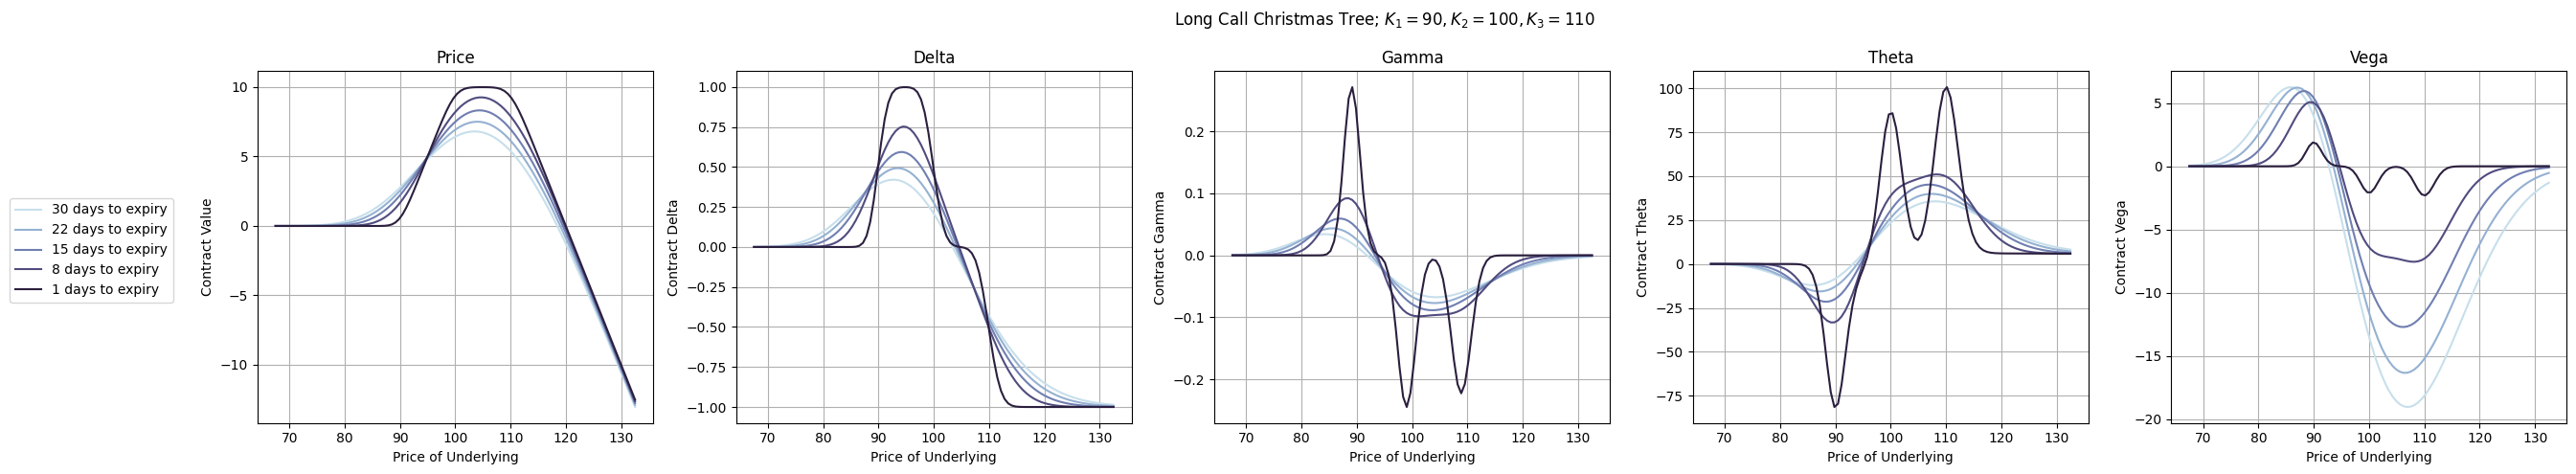

In [109]:
plot_price_greeks(long_xmascall, spot_prices, ts, 
                  f"Long Call Christmas Tree; $K_1={lower_strike:.0f}, K_2={strike_price:.0f}, K_3={upper_strike:.0f}$")

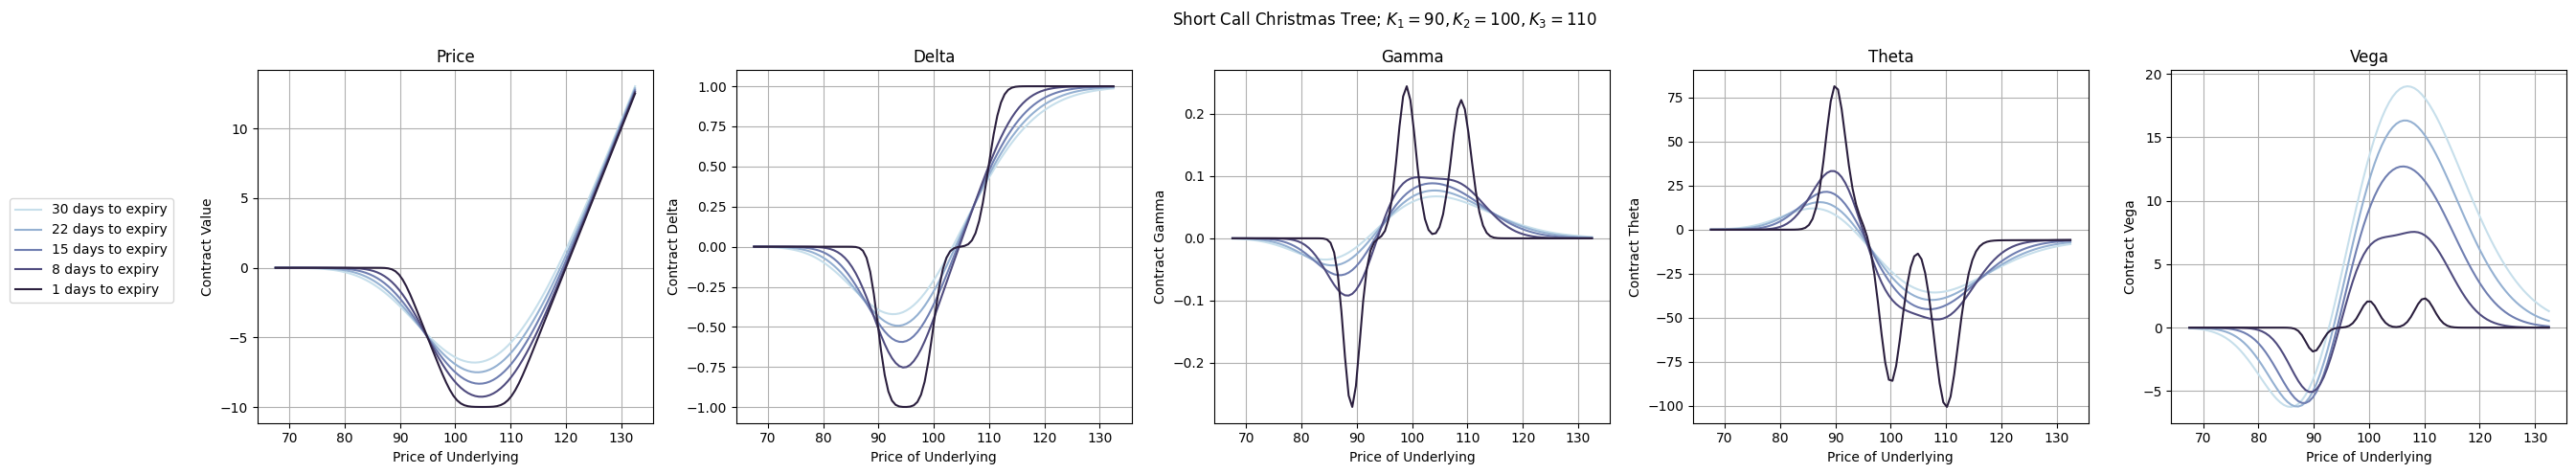

In [110]:
plot_price_greeks(short_xmascall, spot_prices, ts, 
                  f"Short Call Christmas Tree; $K_1={lower_strike:.0f}, K_2={strike_price:.0f}, K_3={upper_strike:.0f}$")

### 7. Long and Short Put Christmas Tree

In [111]:
long_xmasput = StructuredProductFactory.put_xmastree(lower_strike=lower_strike,
                                                     center_strike=strike_price,
                                                     upper_strike=upper_strike,
                                                     time_to_exp=time_to_exp,
                                                     volatility=volatility,
                                                     int_rate=int_rate,
                                                     div_yield=div_yield)

In [112]:
short_xmasput = copy.deepcopy(long_xmasput)
short_xmasput.weights = long_xmasput.weights * -1

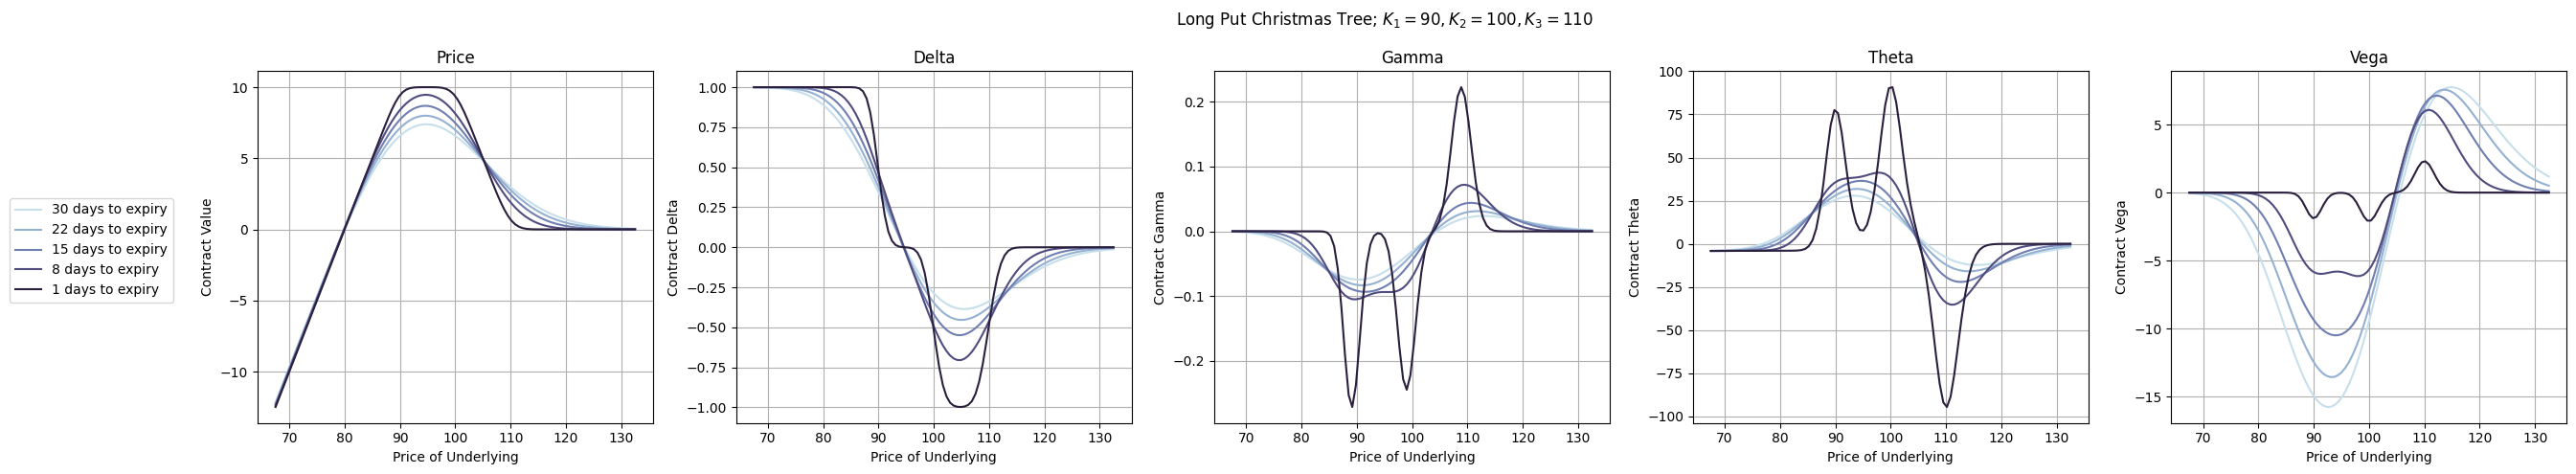

In [113]:
plot_price_greeks(long_xmasput, spot_prices, ts, 
                  f"Long Put Christmas Tree; $K_1={lower_strike:.0f}, K_2={strike_price:.0f}, K_3={upper_strike:.0f}$")

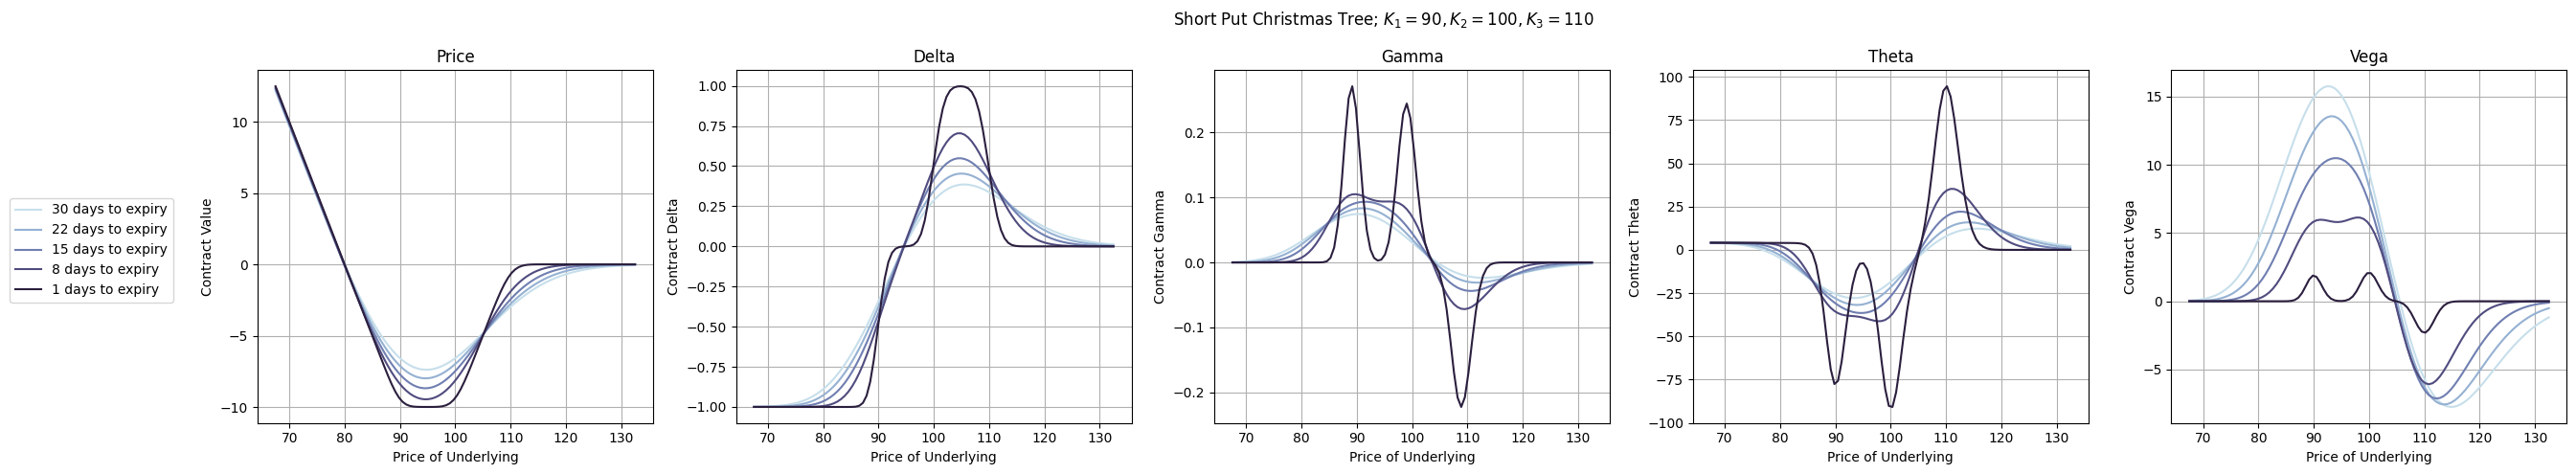

In [114]:
plot_price_greeks(short_xmasput, spot_prices, ts, 
                  f"Short Put Christmas Tree; $K_1={lower_strike:.0f}, K_2={strike_price:.0f}, K_3={upper_strike:.0f}$")

### 8. Calendar Spread

In [115]:
t1 = time_to_exp
t2 = time_to_exp + 30/360

In [116]:
calendar_spread = StructuredProductFactory.calendar_spread(strike=strike_price,
                                                     near_time_to_exp=t1,
                                                     far_time_to_exp=t2,
                                                     volatility=volatility,
                                                     int_rate=int_rate,
                                                     div_yield=div_yield)

In [117]:
t1_days = np.floor(t1 * 360)
t2_days = np.floor(t2 * 360)

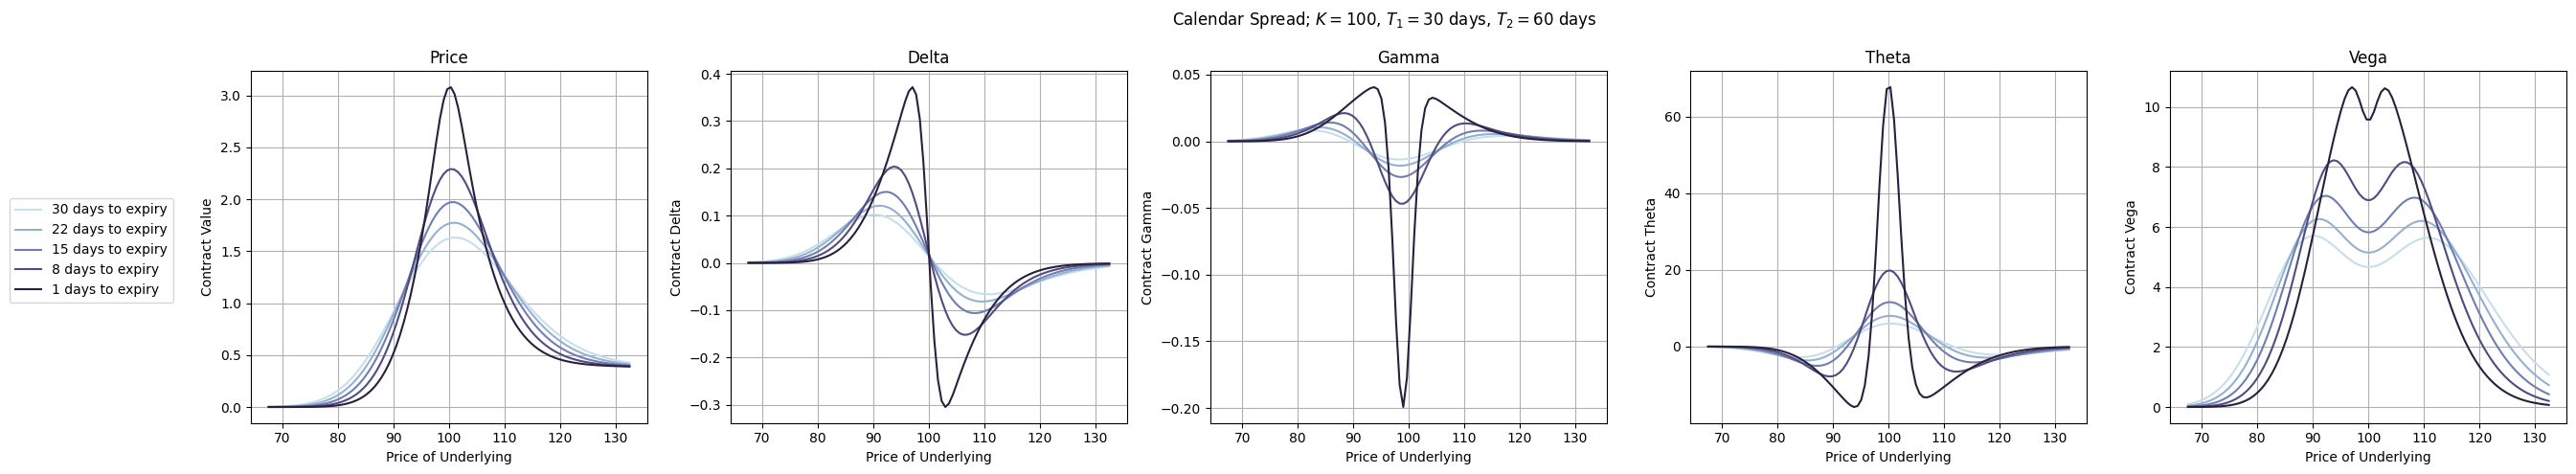

In [118]:
plot_price_greeks(calendar_spread, spot_prices, ts, 
                  f"Calendar Spread; $K={strike_price:.0f}$, $T_1={t1_days:.0f}$ days, $T_2={t2_days:.0f}$ days")